# Analysis of conditional GAN results

In [1]:
# Convenient fudge for python path
import sys
sys.path.append('..')

In [2]:
# Compatibility
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# System
import os
import json

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Locals
from atlasgan import cgan
from atlasgan.datasets import RPVCondImages, inverse_transform_data, generate_noise
from atlasgan.reco import compute_physics_variables

# Magics
%matplotlib notebook

## Load the data

In [3]:
def load_model_config(train_dir):
    config_file = os.path.join(train_dir, 'config.json')
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def load_validation_metrics(metrics_file):
    return pd.DataFrame(dict(np.load(metrics_file)))

In [4]:
# Directory containing all of the training directories we want to process
train_dir = '/data0/sfarrell/atlas_gan/AtlasCondGAN_004'

In [5]:
test_masses = [(1400, 850), (1600, 850), (1800, 850)]
test_files = [
    '/data0/sfarrell/atlas_gan/data/RPV10_1400_850_01_test.npz',
    '/data0/sfarrell/atlas_gan/data/RPV10_1600_850_01_test.npz',
    '/data0/sfarrell/atlas_gan/data/RPV10_1800_850_01_test.npz'
]
metrics_files = [
    os.path.join(train_dir, os.path.basename(f).replace('test', 'metrics'))
    for f in test_files
]

In [6]:
n_test = 4096
datasets = [RPVCondImages(f, n_samples=n_test) for f in test_files]

## Evaluate results

In [7]:
results = []
for (mglu, mneu), metrics_file in zip(test_masses, metrics_files):
    results.append(load_validation_metrics(metrics_file).assign(mglu=mglu, mneu=mneu))
results = pd.concat(results, ignore_index=True)

In [8]:
# Add the combined KS metric
ks_comb = results.ks_jetPt + results.ks_nJet + results.ks_sumMass
results = results.assign(ks_comb=ks_comb)

In [9]:
# Show the best model epochs across all HPs using the combined KS metric
top_k = 10
idx = results.ks_comb.sort_values().index[:top_k]
topk_results = results.loc[idx]
topk_results

,epoch,ks_jetEta,ks_jetPhi,ks_jetPt,ks_nJet,ks_sumMass,mglu,mneu,ks_comb
103,39,110.274034,71.649771,2.919745,2.496965,15.143169,1600,850,20.559878
96,32,19.949701,36.353477,5.646474,7.527176,7.527176,1600,850,20.700826
39,39,101.577677,86.499914,0.368718,13.327967,10.972255,1400,850,24.668940
32,32,18.144674,31.691640,17.564191,7.707837,14.040793,1400,850,39.312821
15,15,64.865125,34.978333,11.570632,10.028939,18.005272,1400,850,39.604843
0,0,225.803963,205.273040,28.927424,8.075051,7.982511,1400,850,44.984985
79,15,77.703851,32.205517,17.841045,19.244617,9.926581,1600,850,47.012243
80,16,108.779844,52.811703,2.279134,26.362809,23.354656,1600,850,51.996599
143,15,74.729941,50.838748,15.748315,31.829770,8.930000,1800,850,56.508084
144,16,70.177215,59.674634,20.219899,26.526043,11.955336,1800,850,58.701277


In [10]:
# Sort by sumMass performance
idx = results.ks_sumMass.sort_values().index[:top_k]
results.loc[idx]

,epoch,ks_jetEta,ks_jetPhi,ks_jetPt,ks_nJet,ks_sumMass,mglu,mneu,ks_comb
107,43,111.289704,56.134075,25.102941,89.747593,2.609858,1600,850,117.460392
41,41,43.773196,211.242014,107.423649,3.265939,3.583810,1400,850,114.273397
43,43,132.652278,68.579966,43.212538,160.753279,4.049452,1400,850,208.015268
159,31,84.066585,243.749491,27.509816,56.808124,5.748794,1800,850,90.066734
96,32,19.949701,36.353477,5.646474,7.527176,7.527176,1600,850,20.700826
0,0,225.803963,205.273040,28.927424,8.075051,7.982511,1400,850,44.984985
143,15,74.729941,50.838748,15.748315,31.829770,8.930000,1800,850,56.508084
91,27,294.046807,28.505660,25.174842,32.548487,9.125388,1600,850,66.848717
79,15,77.703851,32.205517,17.841045,19.244617,9.926581,1600,850,47.012243
95,31,68.531706,229.184946,19.233447,70.090885,9.926581,1600,850,99.250913


In [11]:
# Try to select the best sumMass for both mglu 1400 and 1800, then test it below on 1600
results[results.mglu != 1600].groupby('epoch').ks_sumMass.sum().sort_values()

epoch
43      15.344982
31      26.853778
15      26.935271
39      32.963852
17      40.361382
41      43.152795
63      44.776778
27      46.689429
16      52.726110
25      66.503970
47      67.888629
5       72.913019
58      76.386326
51      78.645816
4       80.699854
55      83.788029
53      99.022960
32      99.955966
37     100.451802
61     106.280821
62     117.480825
38     121.488996
45     124.876636
49     126.058543
18     127.755431
42     128.567179
52     142.157014
1      143.188942
30     173.449668
57     185.181591
         ...     
48     240.842074
3      272.764156
11     309.110410
12     321.125208
2      328.313502
20     331.529318
28     359.370758
0      359.579402
46     379.829149
24     462.188498
14     480.550157
6      496.016790
21     508.121326
44     513.182781
9      523.004406
40     535.610280
50     548.679733
60     554.221314
7      600.783030
59     629.135759
35     686.068783
19     721.007060
56     749.020814
8      848.959024
26  

## Load a model and evaluate on the test sets

In [12]:
def load_model(train_dir, checkpoint_id, model_config):
    """Load generator and discriminator from checkpoint"""
    checkpoint_file = os.path.join(
        train_dir, 'checkpoints', 'model_checkpoint_%03i.pth.tar' % checkpoint_id
    )
    # Load the checkpoint and map onto CPU
    checkpoint = torch.load(checkpoint_file, map_location=lambda storage, loc: storage)
    generator = cgan.Generator(noise_dim=model_config['noise_dim'],
                               cond_dim=model_config['cond_dim'],
                               threshold=model_config['threshold'],
                               n_filters=model_config['n_filters'])
    discriminator = cgan.Discriminator(n_filters=model_config['n_filters'],
                                       cond_dim=model_config['cond_dim'])
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    # Ensure the model is in eval mode
    return generator.eval(), discriminator.eval()

In [13]:
epoch = 39

model_config = load_model_config(train_dir)
generator, discriminator = load_model(train_dir, checkpoint_id=epoch, model_config=model_config)

In [14]:
%%time

real_images, fake_images = [], []
real_vars, fake_vars = [], []

scale = model_config['image_norm']
for dataset in datasets:
    print(dataset.cond.numpy())
    # Real images and reconstructed physics variables
    test_real = Variable(dataset.data, volatile=True)
    test_cond = Variable(dataset.cond.repeat(n_test, 1))
    real_images.append(inverse_transform_data(dataset.data.numpy().squeeze(1), scale=scale))
    real_vars.append(compute_physics_variables(real_images[-1]))
    
    # Generated images and reconstructed physics variables
    test_noise = Variable(generate_noise(n_test, model_config['noise_dim']), volatile=True)
    test_fake = generator(test_noise, test_cond)
    fake_images.append(inverse_transform_data(test_fake.data.numpy().squeeze(1), scale=scale))
    fake_vars.append(compute_physics_variables(fake_images[-1]))

[0.         0.42857143]
[0.4        0.42857143]
[0.8        0.42857143]
CPU times: user 1min 32s, sys: 2.39 s, total: 1min 34s
Wall time: 40.5 s


<IPython.core.display.Javascript object>


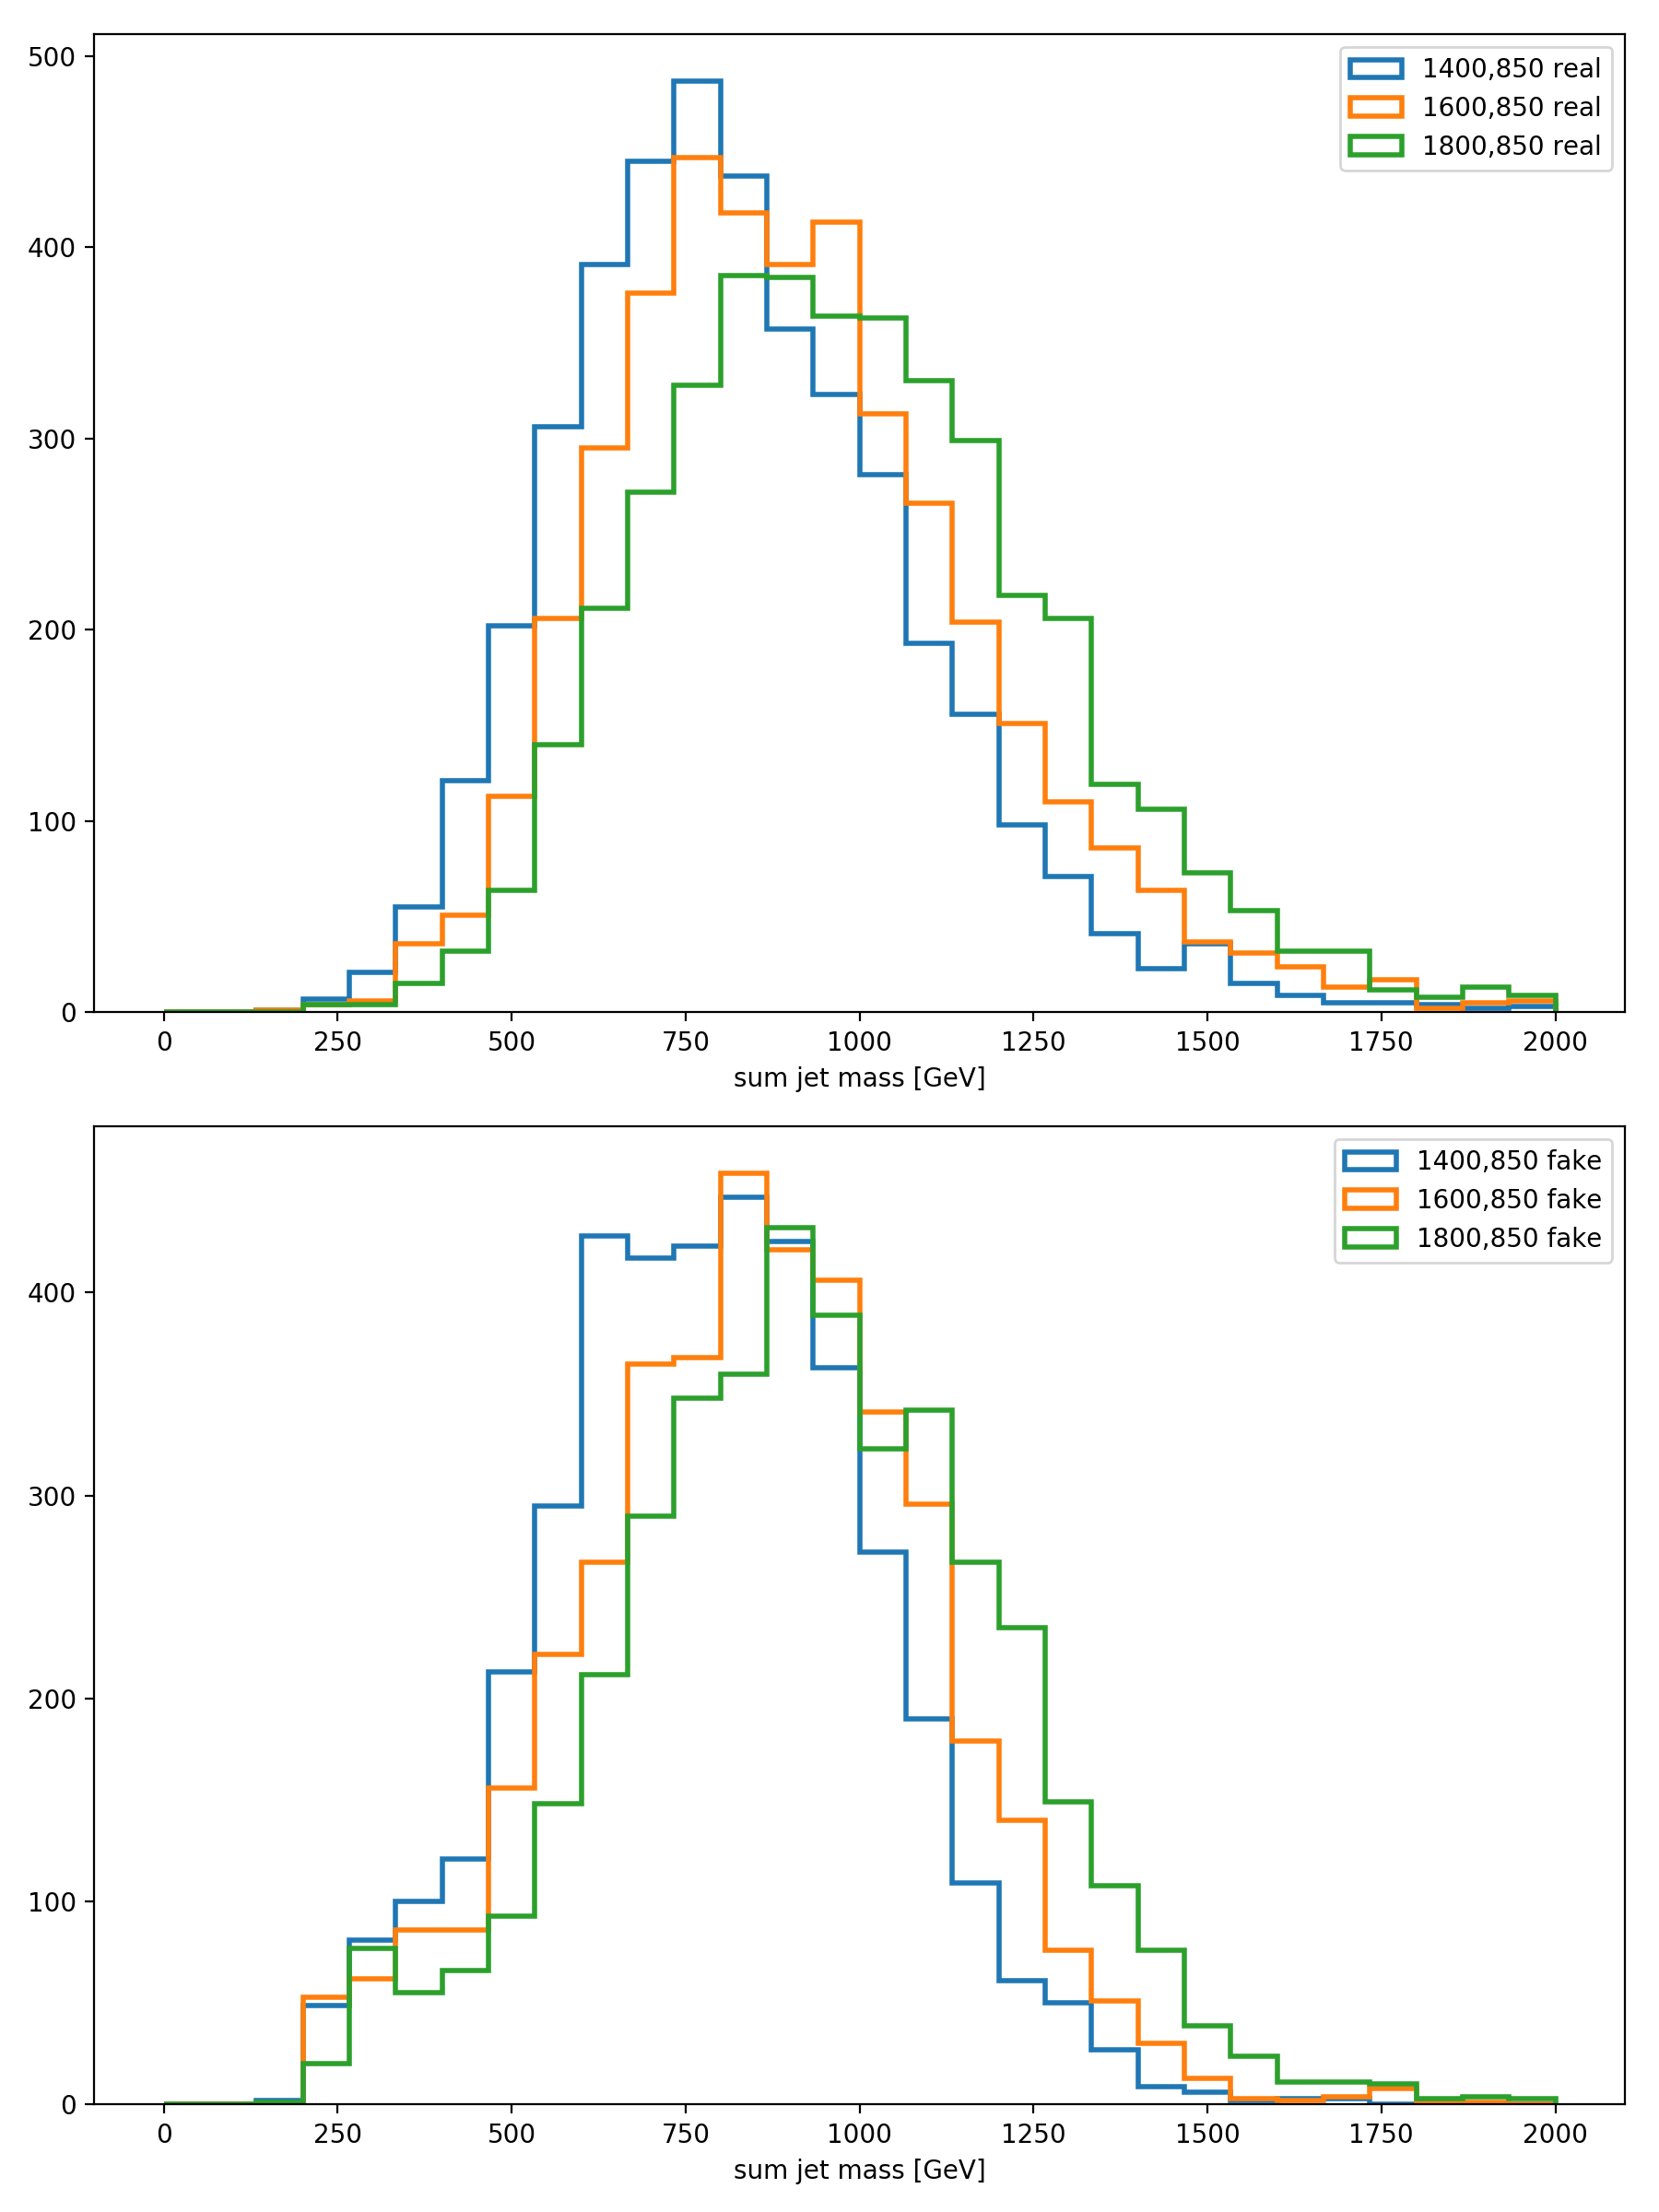

In [16]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 12))

#colors = ['b', 'g', 'r']
hist_args = dict(bins=30, range=(0, 2e3), log=False, histtype='step', linewidth=2)
for i in range(len(real_vars)):
    # Draw real distributions
    ax0.hist(real_vars[i]['sumMass']*1e-3,
             label='%i,%i real' % test_masses[i], **hist_args)
    # Draw generated distributions
    ax1.hist(fake_vars[i]['sumMass']*1e-3,
             label='%i,%i fake' % test_masses[i], **hist_args)
    
ax0.set_xlabel('sum jet mass [GeV]')
ax1.set_xlabel('sum jet mass [GeV]')
plt.tight_layout()
ax0.legend(loc=0)
ax1.legend(loc=0)

<IPython.core.display.Javascript object>


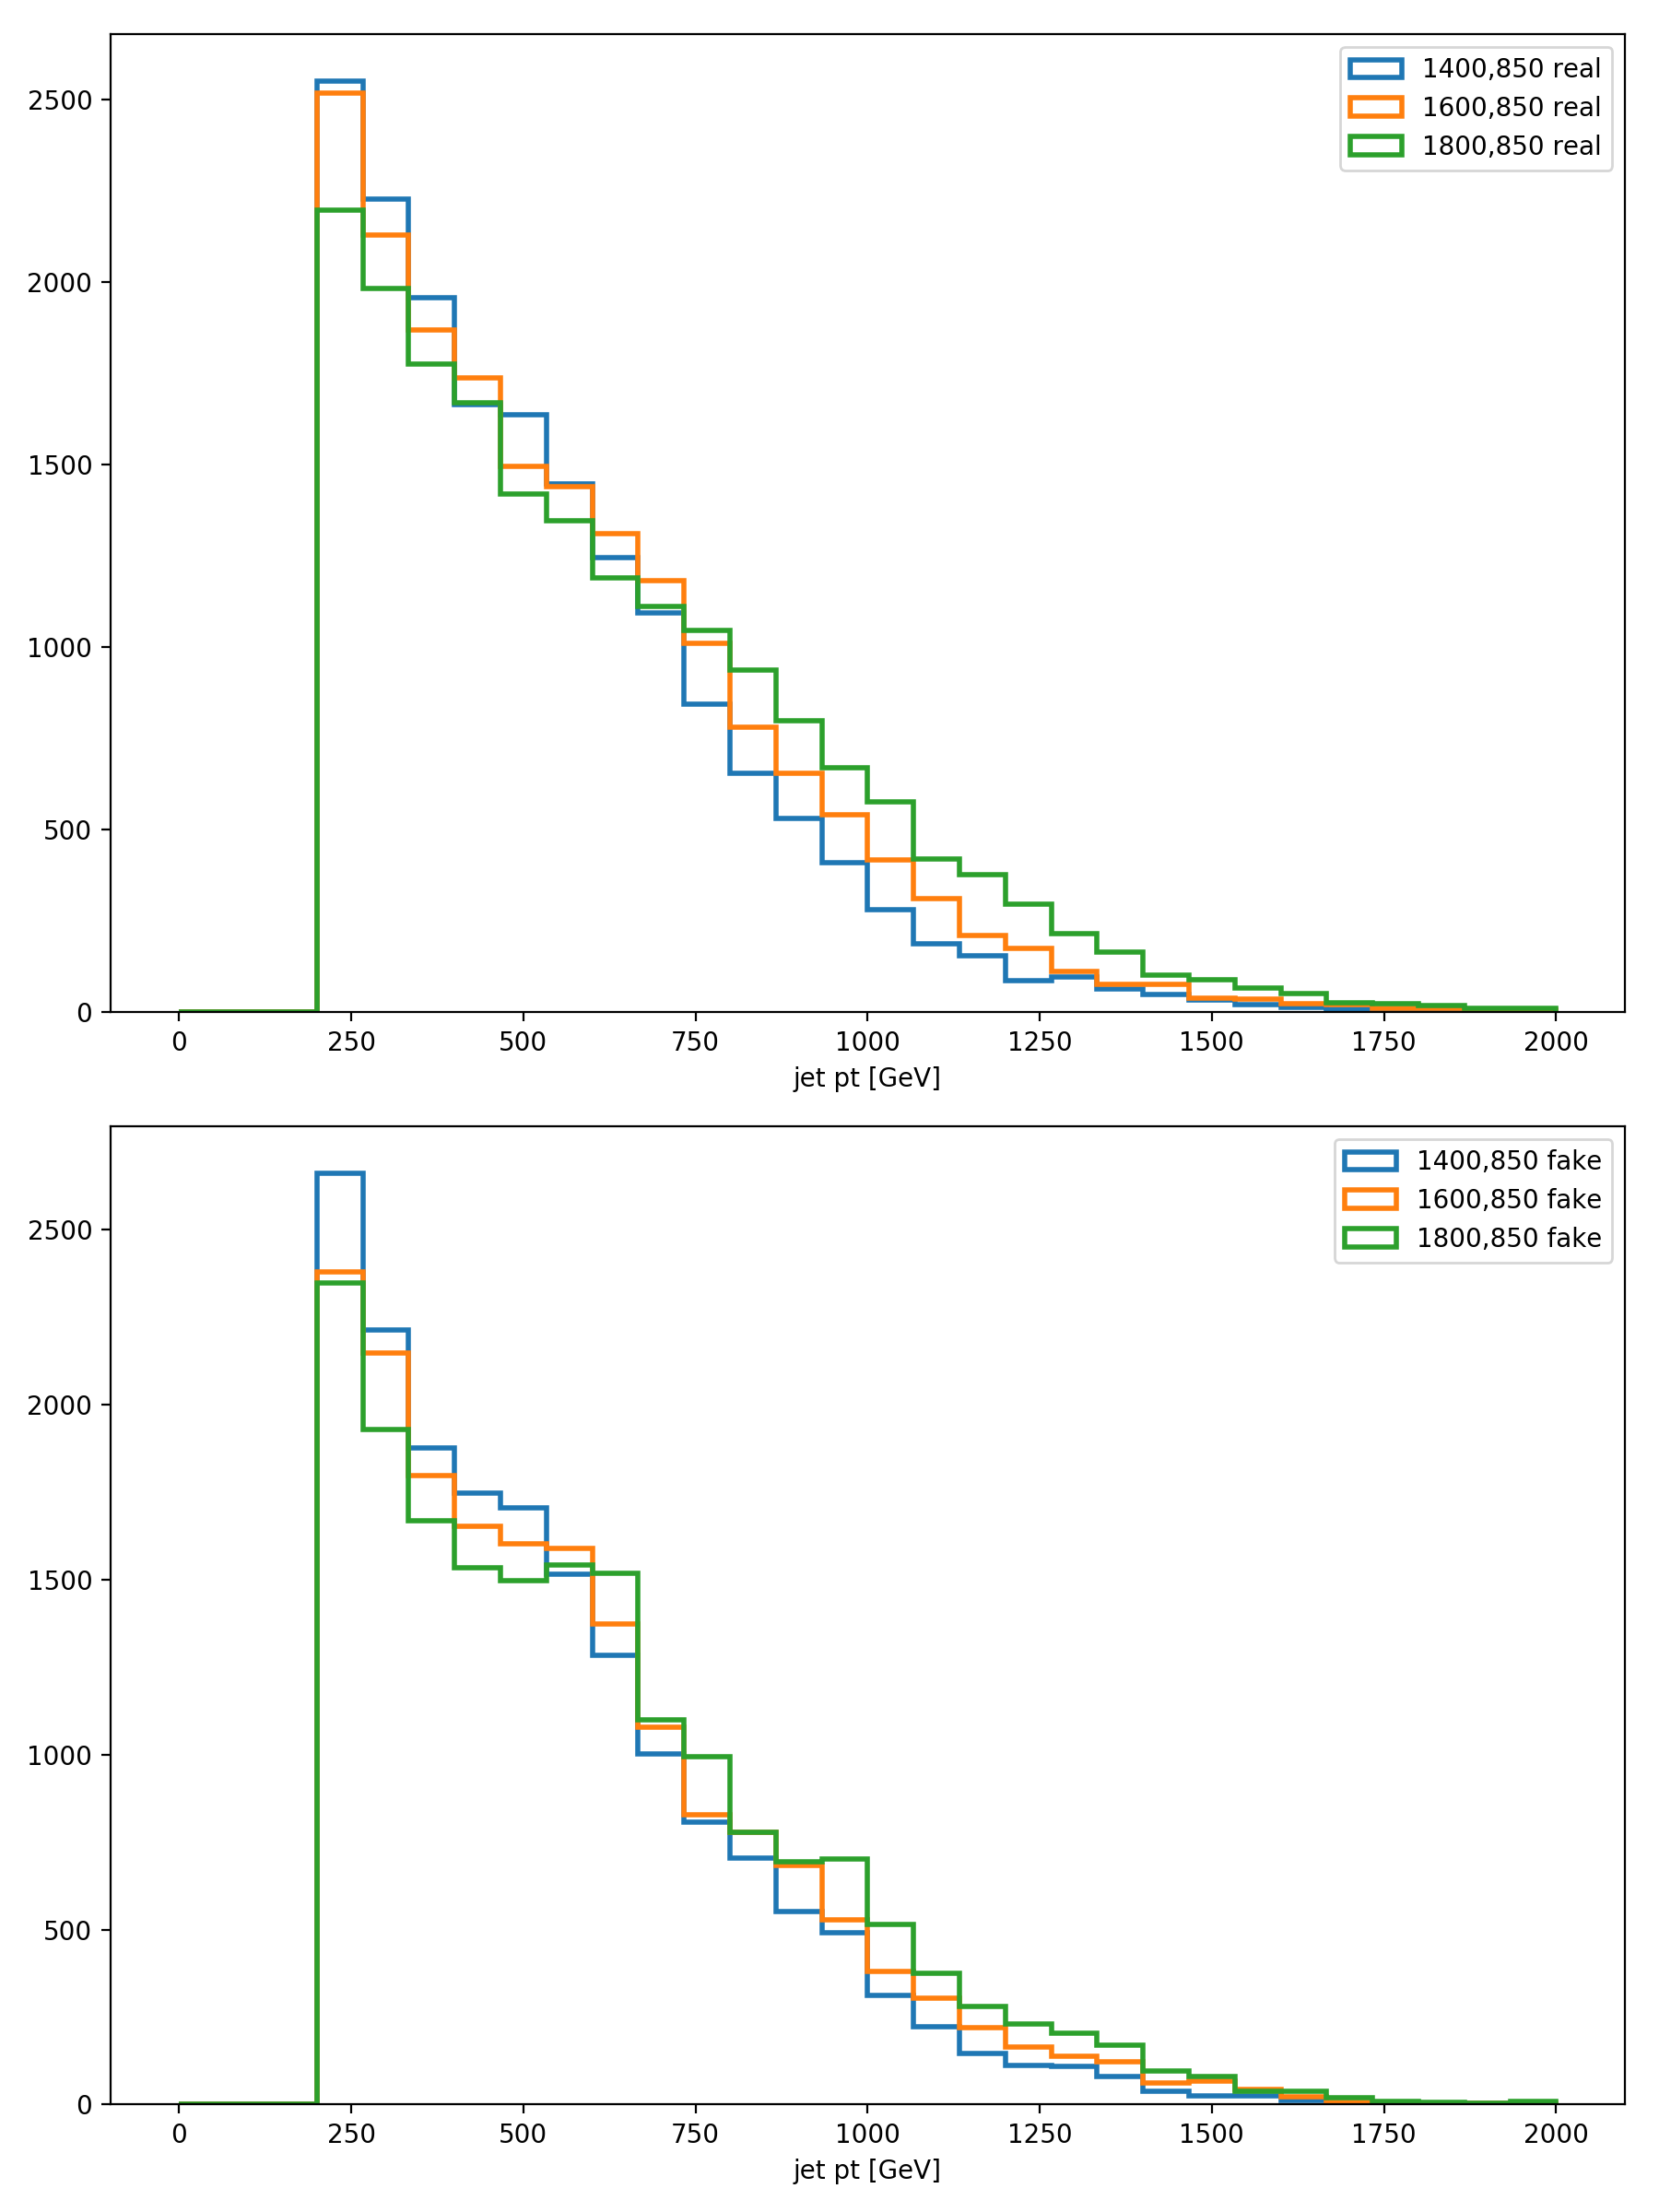

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 12))

#colors = ['b', 'g', 'r']
hist_args = dict(bins=30, range=(0, 2e3), log=False, histtype='step', linewidth=2)
for i in range(len(real_vars)):
    # Draw real distributions
    ax0.hist(real_vars[i]['jetPt']*1e-3,
             label='%i,%i real' % test_masses[i], **hist_args)
    # Draw generated distributions
    ax1.hist(fake_vars[i]['jetPt']*1e-3,
             label='%i,%i fake' % test_masses[i], **hist_args)
    
ax0.set_xlabel('jet pt [GeV]')
ax1.set_xlabel('jet pt [GeV]')
plt.tight_layout()
ax0.legend(loc=0)
ax1.legend(loc=0)

<IPython.core.display.Javascript object>


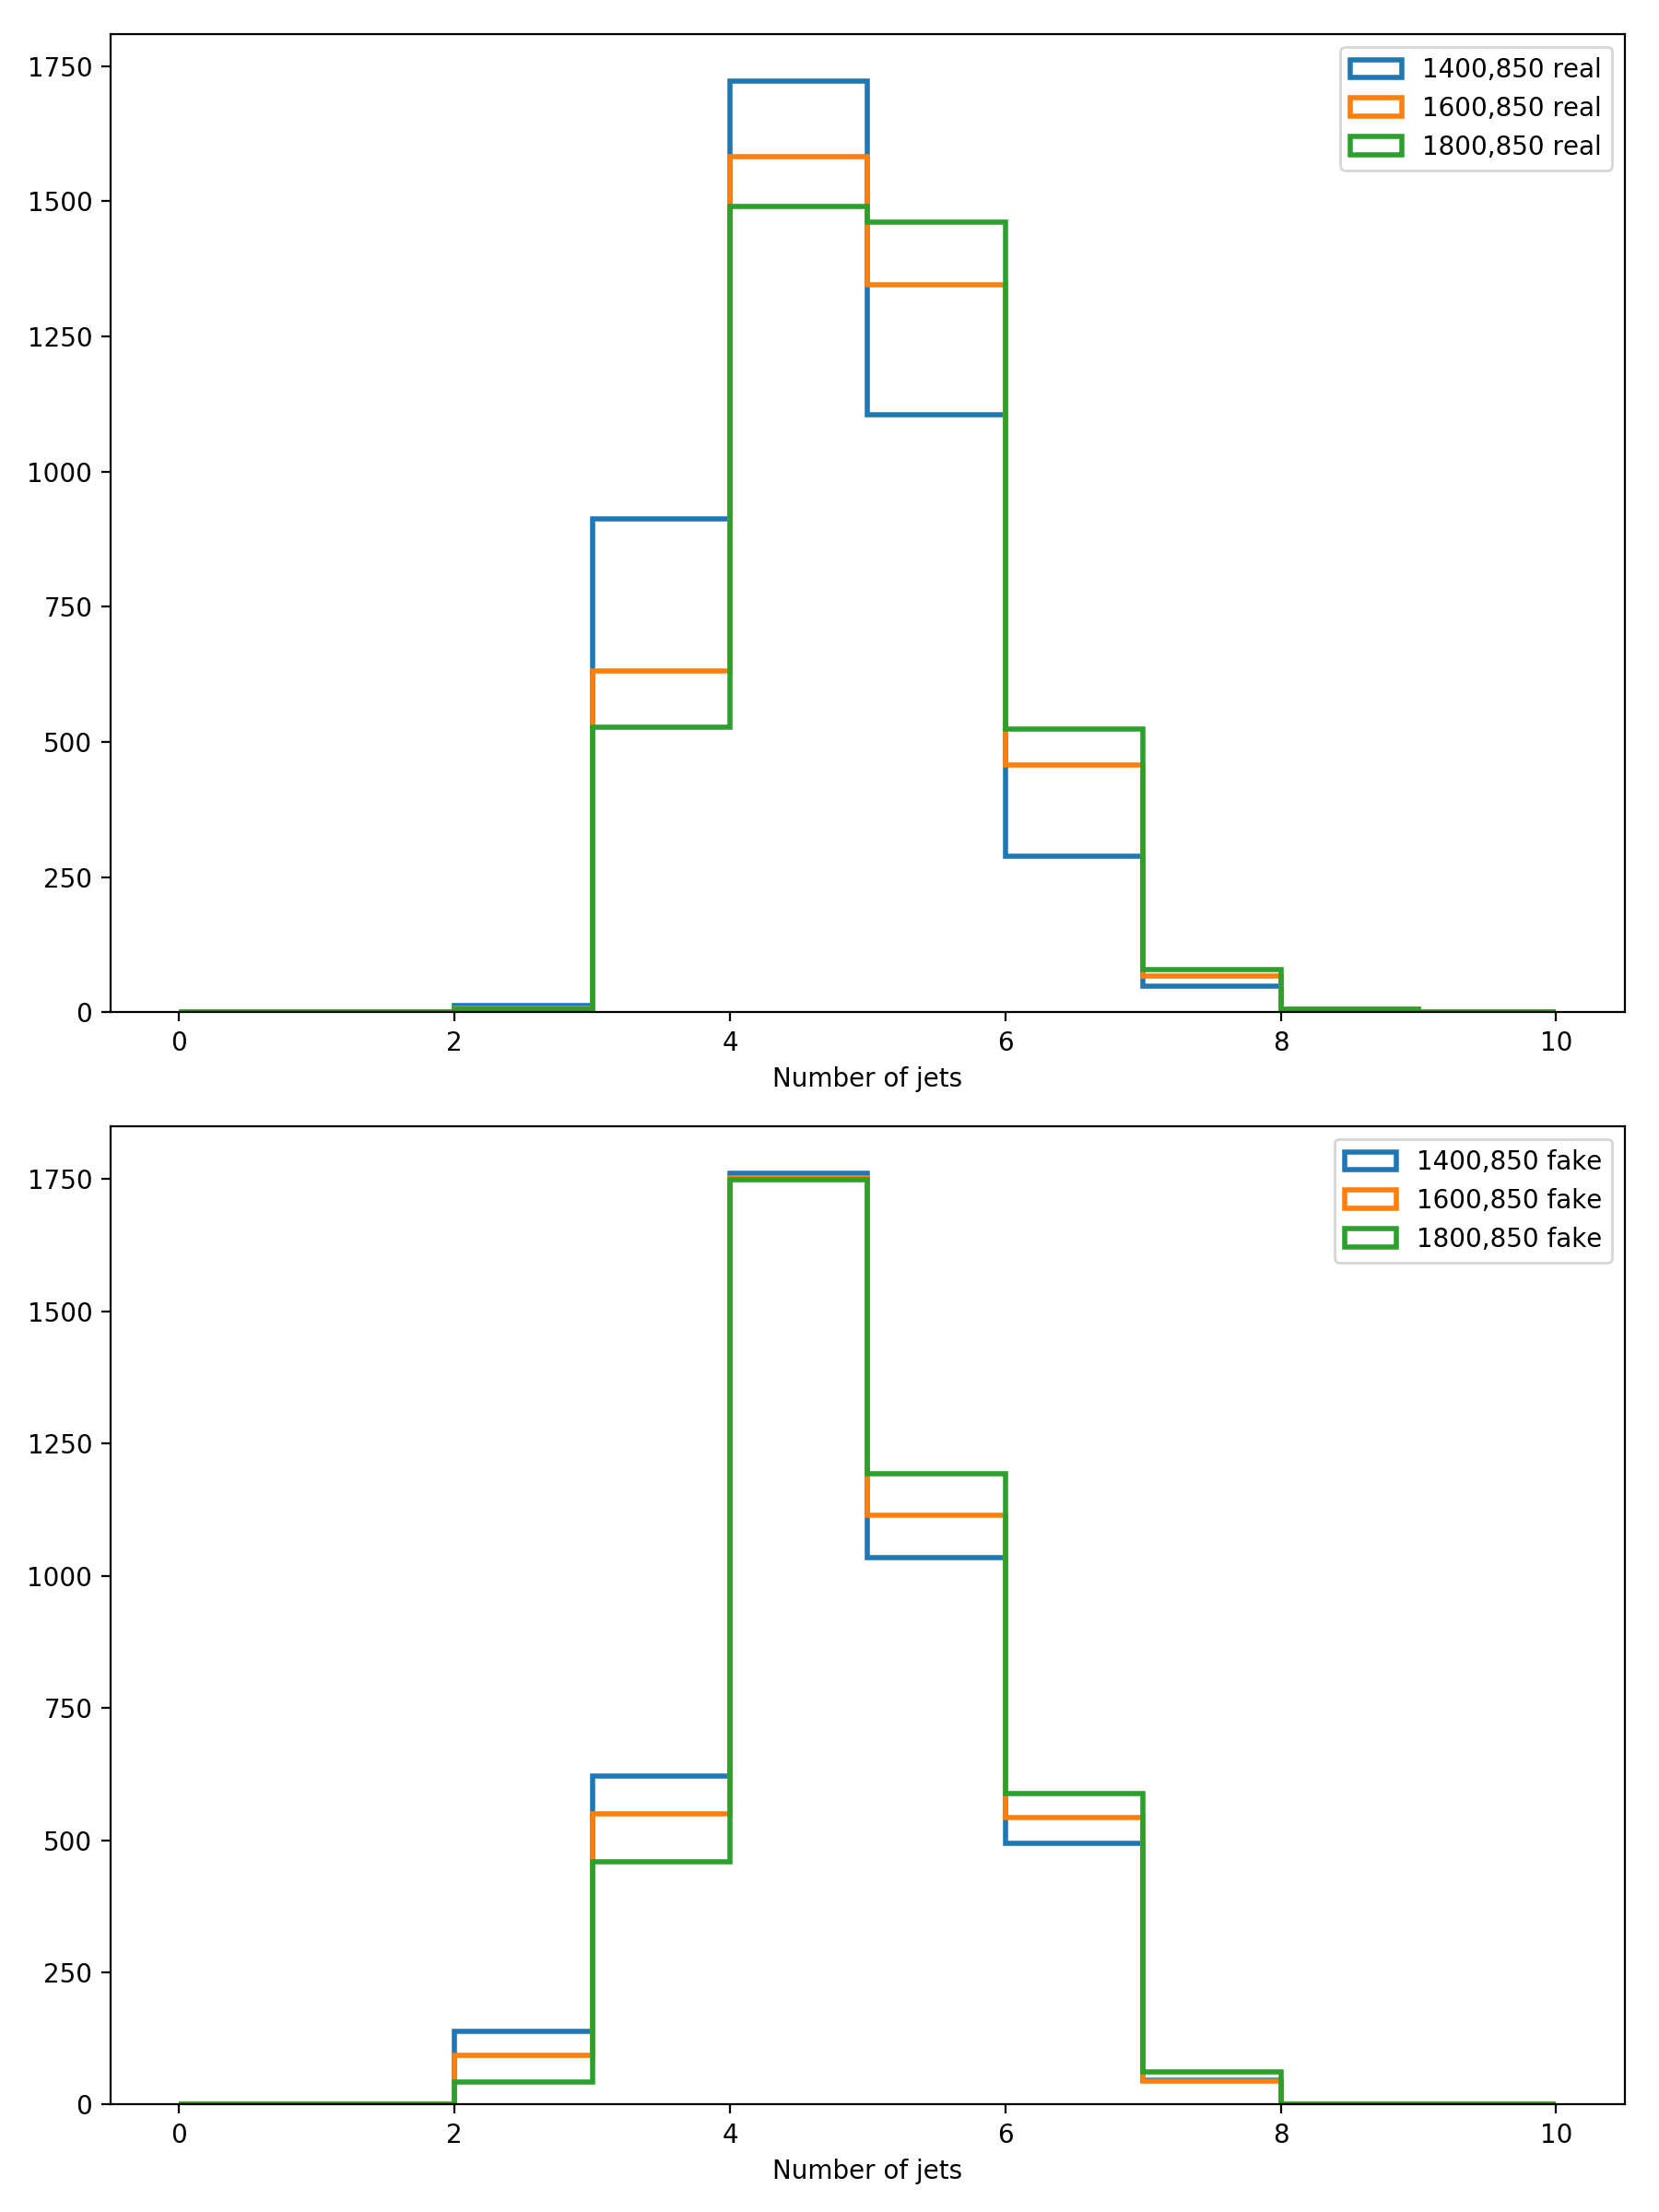

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 12))

#colors = ['b', 'g', 'r']
hist_args = dict(bins=10, range=(0, 10), log=False, histtype='step', linewidth=2)
for i in range(len(real_vars)):
    # Draw real distributions
    ax0.hist(real_vars[i]['nJet'],
             label='%i,%i real' % test_masses[i], **hist_args)
    # Draw generated distributions
    ax1.hist(fake_vars[i]['nJet'],
             label='%i,%i fake' % test_masses[i], **hist_args)
    
ax0.set_xlabel('Number of jets')
ax1.set_xlabel('Number of jets')
plt.tight_layout()
ax0.legend(loc=0)
ax1.legend(loc=0)